# Fake News Detection

During the **text preprocessing**，I didn't use the ```CountVectorizer``` class from **scikit-learn** to preprocess the text, because I want to go beyond the functionality provided by this library and understand the implementation process of text segmentation. So, I tokenized the text manually and added some new tokenization features that are important for news texts.

+ Split contractions (e.g. don't --> do not)
+ Remove all numbers
+ Transform words into lemmas
+ Transform words into stems

For the text that has already been segmented, I selected **four vectorization methods**, specifically **document frequency** and **TF-IDF** within the Bag-of-Words model, **Word2Vec** within the Word Embedding model, and **Convolutional Neural Network (CNN)** within the Deep Learning model. The reason for this is that I intended to examine the characteristics of the text vector matrices obtained through different word vectorization methods.   

Moreover, in the subsequent **news classification tasks**, for machine learning models (**Gaussian Naive Bayes, Random Forest, Support Vector Machine, Feedforward Neural Network**) with the same parameter settings, I wanted to see how different input features would affect the prediction accuracy of each model and **which combination of the matrix derived from a particular word vectorization method and a specific machine learning model would yield a higher accuracy**.

Finally, the conclusions are as follows:
- After controlling the dimensions of the input features to be consistent, compared with the text vector matrices represented by the other three vectorization methods, the models obtained by combining TF-IDF with the four machine learning models have the most excellent accuracy and generalization ability.
- After controlling the input feature to be the **TF-IDF text vector matrix**, the performances of the Random Forest, Support Vector Machine, and Feedforward Neural Network models are all relatively good. Among them, **the Support Vector Machine model equipped with a nonlinear kernel** has the best accuracy in the news classification task, with a **final accuracy score of 0.9558**.

Reference:
- Ash, E., & Hansen, S. (2023). Text algorithms in economics. Annual Review of Economics, 15(Volume 15, 2023), 659–688. https://doi.org/10.1146/annurev-economics-082222-074352
- Heinrich, G. (2009). Parameter estimation for text analysis. https://www.semanticscholar.org/paper/Parameter-estimation-for-text-analysis-Heinrich/f22d042312f5f38eddaca08d49ef805c0d8f1cdc

Code Reference:
- https://github.com/sekhansen/text_algorithms_econ/blob/3d3042e96254a92a4bbcb181a33ced091de49724/notebooks/2_preprocessing.ipynb


## Data
- train.csv: A full training dataset with the following attributes:
    - id: unique id for a news article
    - title: the title of a news article
    - author: author of the news article
    - text: the text of the article; could be incomplete
    - label: a label that marks the article as potentially unreliable
        - 1: unreliable
        - 0: reliable
        
Data publicly available: Fake News | Kaggle: https://www.kaggle.com/competitions/fake-news/data?select=submit.csv


## 0 Load data
Load the dataset "train.csv" which has already been marked with labels indicating whether the news is real or fake. It can be seen from the table that there are a total of 20,800 pieces of news, and **both the "title" column and the "text" column** contain English texts that need to be preprocessed. 

In [ ]:
%%capture

# NLP 
!pip3 install nltk 
!pip3 install flashtext
!pip3 install requests
!pip3 install jinja2

!pip3 install spacy
# Because I can't load via "!python3 -m spacy download en_core_web_sm"
# Download the language pack directly from the English · spaCy Models Documentation: https://spacy.io/models/en, and then load it by indexing to the file.
!pip3 install 'E:/2024XA/nlp/en_core_web_sm-3.8.0-py3-none-any.whl' 

# Word2Vec 
!pip3 install gensim 

In [ ]:
# clone the GitHub repository with the preprocessing scripts
# The stop word data provided by the author will be used later
!git clone https://github.com/unstructured-data-research/text-preprocessing


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('E:/2024计算社会科学夏校/hw/day8/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.shape

(20800, 5)

In [5]:
# check missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
# Replace missing values with spaces
df = df.fillna(' ')

In [7]:
# View the information of the text column of the first news
df.loc[0,'text']

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [8]:
df.loc[0,'title']

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [9]:
# merge text messages
df['docs'] = df['title'] + ' ' + df['text']
docs = df['docs']

In [10]:
docs

0        House Dem Aide: We Didn’t Even See Comey’s Let...
1        FLYNN: Hillary Clinton, Big Woman on Campus - ...
2        Why the Truth Might Get You Fired Why the Trut...
3        15 Civilians Killed In Single US Airstrike Hav...
4        Iranian woman jailed for fictional unpublished...
                               ...                        
20795    Rapper T.I.: Trump a ’Poster Child For White S...
20796    N.F.L. Playoffs: Schedule, Matchups and Odds -...
20797    Macy’s Is Said to Receive Takeover Approach by...
20798    NATO, Russia To Hold Parallel Exercises In Bal...
20799    What Keeps the F-35 Alive   David Swanson is a...
Name: docs, Length: 20800, dtype: object

## 1 Text preprocessing
I grasped the significance of text preprocessing from this [GitHub post](https://github.com/sekhansen/text_algorithms_econ/blob/main/notebooks/2_preprocessing.ipynb). According to my own requirements, I referred to some of the author's code and developed my own text preprocessing approach.

### 1.1 Basic cleaning

In [11]:
# lower case via the lower() built-in method
docs = [s.lower() for s in docs]

In [12]:
# remove leading and trailing whitespaces
docs = [d.strip() for d in docs]

In [13]:
import contractions

# split contractions with the "contractions" library
# the library mainly supports English but it provides the tools to extend its
# functionality to other languages: https://github.com/kootenpv/contractions
contractions.fix("We can't increase the interest rate. They won't accept it. It's too risky.")

'We cannot increase the interest rate. They will not accept it. It is too risky.'

In [14]:
# apply contractions function
docs = list(map(lambda x: contractions.fix(x), docs))

In [15]:
docs[0]

'house dem aide: we did not even see comey’s letter until jason chaffetz tweeted it house dem aide: we did not even see comey’s letter until jason chaffetz tweeted it by darrell lucus on october 30, 2016 subscribe jason chaffetz on the stump in american fork, utah ( image courtesy michael jolley, available under a creative commons-by license) \nwith apologies to keith olbermann, there is no doubt who the worst person in the world is this week–fbi director james comey. but according to a house democratic aide, it looks like we also know who the second-worst person is as well. it turns out that when comey sent his now-infamous letter announcing that the fbi was looking into emails that may be related to hillary clinton’s email server, the ranking democrats on the relevant committees did not hear about it from comey. they found out via a tweet from one of the republican committee chairmen. \nas we now know, comey notified the republican chairmen and democratic ranking members of the house

In [16]:
import nltk 

# Customized regular expression pattern that preserves punctuation and hyphenated words will be split
custom_pattern = r'''
                 (?x)                   # set flag to allow verbose regexps (to separate logical sections of pattern and add comments)
                 \w+                    # Match a single word. Two word parts connected by a hyphen, which will later be split into two tokens
                 | [][.,;"'?():-_`]     # Keep punctuation as separate tokens
                 '''

# apply the pattern
tokens_custom = list(map(lambda x: nltk.regexp_tokenize(x, pattern=custom_pattern), docs))

In [17]:
# inspect a document to see the tokenization
print(df.loc[0, "docs"][0:120], "\n")
print(tokens_custom[0][0:20]) 


House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It House Dem Aide: We Didn’t Even See Com 

['house', 'dem', 'aide', ':', 'we', 'did', 'not', 'even', 'see', 'comey', 's', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'it', 'house', 'dem', 'aide']


In [18]:
import unicodedata

# remove non-ascii characters via unicodedata package
def remove_non_ascii(tokens):
    tokens = [unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore') for t in tokens]
    return tokens
    
# apply function
tokens_custom = list(map(remove_non_ascii, tokens_custom))

In [19]:
print(tokens_custom[0][0:20])

['house', 'dem', 'aide', ':', 'we', 'did', 'not', 'even', 'see', 'comey', 's', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'it', 'house', 'dem', 'aide']


In [20]:
# remove extra white spaces and short tokens via simple list comprehension
def remove_short(tokens, min_length=2):
    return [t.strip() for t in tokens if t.strip() != '' and len(t.strip()) > min_length] 

# apply function
tokens_custom = list(map(remove_short, tokens_custom))

In [21]:
print(tokens_custom[0][0:20])

['house', 'dem', 'aide', 'did', 'not', 'even', 'see', 'comey', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'house', 'dem', 'aide', 'did', 'not', 'even', 'see']


In [22]:
import string
import re

# remove punctuation using a regular expression. We can use this same 
# structure to remove any other character
def remove_punctuation(tokens, punctuation):            
    regex = re.compile('[%s]' % re.escape(punctuation))
    tokens = [regex.sub('', t) for t in tokens]
    return tokens

# load a list of punctuation signs
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
# apply function
tokens_custom = list(map(lambda x: remove_punctuation(x, string.punctuation), tokens_custom))
print(tokens_custom[0][0:16])

['house', 'dem', 'aide', 'did', 'not', 'even', 'see', 'comey', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'house', 'dem', 'aide']


In [24]:
import spacy
nlp_standard = spacy.load('en_core_web_sm')
import flashtext

# Import modules created by the author
import sys
sys.path.append('./text-preprocessing/src') # Index into the cloned git hub file under the current path
import preprocessing_class as pc
import preprocess_data

In [25]:
# remove stopwords via simple list comprehension
def remove_stopwords(tokens, stopwords):
    return [t for t in tokens if t not in stopwords]

# load a custom list of stopwords
custom_stopwords = list(preprocess_data.stp_long)
custom_stopwords[0:10]

['more',
 'be',
 'below',
 'your',
 'five',
 'she',
 'ours',
 'before',
 'my',
 'theirs']

In [26]:
# apply stopword removal function
tokens_custom = list(map(lambda x: 
                  remove_stopwords(x, stopwords=custom_stopwords),
                  tokens_custom))

In [27]:
print(tokens_custom[0][0:20])

['house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'darrell', 'lucus', 'october', '2016']


In [28]:
# remove numbers
def remove_numbers(tokens, min_length=2):
    translation_table = str.maketrans('', '', string.digits)
    tokens = [t.translate(translation_table) for t in tokens if not t.isdigit()] 
    return  [t for t in tokens if t != '' and len(t) > min_length]

# apply number removal function
tokens_custom = list(map(lambda x: 
                  remove_numbers(x, min_length=2),
                  tokens_custom))

In [29]:
print(tokens_custom[0][0:20])

['house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'darrell', 'lucus', 'october', 'subscribe']


### 1.2 Stemming and lemmatization
As a next step, one might attempt to group together words that are grammatically different but thematically identical. For example, it could be reasonable to keep words such as *'obligations'*, *'obligation'* and  *'oblige'* under a single token. Ultimately these three words denote the same concept, and so we might want them to share the same symbol. 

The two most popular techniques to achieve this goal are **stemming** and **lemmatization**.  
>Stemming replaces each word with its root form. The resulting token is less readable by humans but encompases multiple words (e.g. *'tradition'* and *'traditional'* have the same stem: *'tradit'*). 

>Lemmatization replaces words with their dictionary form i.e. lemma. The words *'changing'*, *'changes'* and *'changed'* all have the same lemma: *'change'*.

Below, we use both techniques (stemming [via nltk Snowball stemmer](https://www.geeksforgeeks.org/snowball-stemmer-nlp/) and lemmatization via [spaCy lemmatizer](https://spacy.io/api/lemmatizer)) and look at the different results on a specific document.  

The above text refers to the [author's notebook](https://github.com/sekhansen/text_algorithms_econ/blob/3d3042e96254a92a4bbcb181a33ced091de49724/notebooks/2_preprocessing.ipynb).

Although I applied both of these methods, since the vectorization stage involves semantic associations among words, I chose to use the tokens obtained through **lemmatization** for the word vectorization stage.

#### 1.2.1 Stemming

In [30]:
from nltk import SnowballStemmer

# stem via standard nltk Snowball Stemmer
stemmer = SnowballStemmer(language='english')
def stem(tokens):
    """stem all tokens that do not contain hyphens"""
    return [stemmer.stem(t) if "-" not in t else t for t in tokens]

# apply function
stems = list(map(stem, tokens_custom))

In [31]:
count_stems = 0
for sub_list in stems:
    for _ in sub_list:
        count_stems += 1
print("The total number of stems is:", count_stems)

The total number of stems is: 8113711


In [32]:
def text_lengths(token_list):
    text_lengths = [len(text) for text in token_list]
    min_length = min(text_lengths)
    max_length = max(text_lengths)
    average_length = sum(text_lengths)/len(text_lengths)
    median_length = sorted(text_lengths)[len(text_lengths)//2]
    print("Minimum text length:", min_length)
    print("Maximum text length:", max_length)
    print("Average text length:", average_length)
    print("Median text length:", median_length)

In [33]:
# calculates and prints the minimum, maximum, average, and median lengths
text_lengths(stems)

Minimum text length: 0
Maximum text length: 11066
Average text length: 390.0822596153846
Median text length: 294


In [34]:
from collections import Counter

# Use counter to count the number of occurrences of each word. It returns a dictionary where the key is the word and the value is the word frequency.
words_count = Counter(stems[0])

# 获取不同词的数量，也就是字典的键的数量
unique_count = len(words_count)
print(words_count)
print("The number of different stems in the first news article is:", unique_count)

Counter({'chaffetz': 15, 'comey': 11, 'letter': 8, 'democrat': 8, 'know': 8, 'republican': 8, 'hous': 7, 'committe': 7, 'aid': 6, 'jason': 6, 'tweet': 6, 'fbi': 6, 'darrel': 5, 'turn': 5, 'email': 5, 'rank': 5, 'member': 5, 'worst': 4, 'may': 4, 'chairmen': 4, 'case': 4, 'dem': 3, 'person': 3, 'world': 3, 'accord': 3, 'look': 3, 'oversight': 3, 'investig': 3, 'alreadi': 3, 'twitter': 3, 'right': 3, 'suggest': 3, 'lucus': 2, 'octob': 2, 'utah': 2, 'courtesi': 2, 'director': 2, 'hillari': 2, 'relev': 2, 'found': 2, 'notifi': 2, 'review': 2, 'inform': 2, 'chairman': 2, 'polit': 2, 'light': 2, 'appar': 2, 'fact': 2, 'year': 2, 'worth': 2, 'time': 2, 'receiv': 2, 'let': 2, 'explos': 2, 'daili': 2, 'kos': 2, 'noth': 2, 'far': 2, 'someth': 2, 'vote': 2, 'religi': 2, 'christian': 2, 'connect': 2, 'subscrib': 1, 'stump': 1, 'american': 1, 'fork': 1, 'imag': 1, 'michael': 1, 'jolley': 1, 'avail': 1, 'creativ': 1, 'common': 1, 'licens': 1, 'apolog': 1, 'keith': 1, 'olbermann': 1, 'doubt': 1, 'wee

#### 1.2.2 Lemmatization

In [35]:
# lemmatize with standard spaCy lemmatizer (takes a couple of minutes)
nlp_standard = spacy.load('en_core_web_sm')
def lemmatize_sent(sent):
    sent = ' '.join(sent)
    doc = nlp_standard(sent)
    lemmas = [token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc]
    return lemmas

# apply function
lemmas = list(map(lemmatize_sent, tokens_custom))

In [36]:
count_lemmas = 0
for sub_list in lemmas:
    for _ in sub_list:
        count_lemmas += 1
print("The total number of lemmas is:", count_lemmas)

The total number of lemmas is: 8120623


In [37]:
# calculates and prints the minimum, maximum, average, and median lengths
text_lengths(lemmas)

Minimum text length: 0
Maximum text length: 11090
Average text length: 390.4145673076923
Median text length: 294


In [38]:
# total_count_ is a dictionary used to store the count of each list
total_count_ = {'tokens_custom': 0, 'stems': 0, 'lemmas': 0}

# Iterate through these three lists and count them separately
for tokens_name, tokens in zip(['tokens_custom', 'stems', 'lemmas'], [tokens_custom, stems, lemmas]):
    for sub_list in tokens:
        # Count the elements of each sublist
        total_count_[tokens_name] += len(sub_list)

print(total_count_)


{'tokens_custom': 8113711, 'stems': 8113711, 'lemmas': 8120623}


In [39]:
# compare the same document
i = 0
print(df.loc[i, "docs"][0:162], "\n")
print("tokens_custom: ", tokens_custom[i][0:20], "\n")
print("Stems: ", stems[i][0:20], "\n")
print("Lemmas: ", lemmas[i][0:20])

House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted I 

tokens_custom:  ['house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'darrell', 'lucus', 'october', 'subscribe'] 

Stems:  ['hous', 'dem', 'aid', 'comey', 'letter', 'jason', 'chaffetz', 'tweet', 'hous', 'dem', 'aid', 'comey', 'letter', 'jason', 'chaffetz', 'tweet', 'darrel', 'lucus', 'octob', 'subscrib'] 

Lemmas:  ['house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweet', 'house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweet', 'darrell', 'lucus', 'october', 'subscribe']


### 1.3 Restricting the vocabulary by looking at the term frequency

Finally, one might want to drop very frequent terms, as they could be regarded as corpus-specific terms that do not add up much value. Similarly, one might want to drop very rare terms, considering that not much can be learnt from such infrequent items. Here I used lemmatization as an example.

To explore these ideas we will rank tokens according to pure document frequency (df) or term frequency inverse document frequency (tf-idf), where high weight is given to terms that appear frequently in the entire dataset, but in relatively few documents. In particular, the tf-idf score for term $v$ is computed according to the formula below:

\begin{equation}
tfidf_v = (1+log(tf_v)) (log \frac{N}{df_v+1})
\end{equation}

In [40]:
def do_nothing(docs):
    return docs

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from collections import defaultdict

def chunk_tokens(tokens, chunk_size):
    """Generator function to split tokens into chunks."""
    for i in range(0, len(tokens), chunk_size):
        yield tokens[i:i + chunk_size]

tokens = lemmas  # token list
chunk_size = 1000  # Number of rows processed each time

# Dictionary to keep track of document frequency for each term
df_dict = defaultdict(int)

# Process tokens in chunks
for chunk in chunk_tokens(tokens, chunk_size):
    print(f"Processing chunk of size {len(chunk)}")

    # Generate document frequency ranking for the current chunk
    vectorizer = TfidfVectorizer(use_idf=False, norm=None, tokenizer=do_nothing, preprocessor=do_nothing)
    df_matrix = vectorizer.fit_transform(chunk)  # Term-document matrix for the chunk
    df_matrix_bool = (df_matrix > 0).astype(int)  # Binary matrix: 1 if term is present, 0 otherwise

    # Sum the binary matrix across rows to get document frequency for the chunk
    scores_df = df_matrix_bool.sum(axis=0).A1  # .A1 converts the matrix to a 1D array (dense form)

    # Update global document frequency dictionary
    for term, idx in vectorizer.vocabulary_.items():
        df_dict[term] += scores_df[idx]  # Increment document frequency for the term

# Now sort the terms by document frequency
sorted_terms = sorted(df_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted terms and their document frequencies
sorted_vocab_keys = [term for term, _ in sorted_terms]
sorted_scores_df = [score for _, score in sorted_terms]
df_ranking = list(zip(sorted_vocab_keys, sorted_scores_df))

# Convert document frequencies to log scale (using natural log)
log_sorted_scores_df = np.log(np.array(sorted_scores_df) + 1)  # Adding 1 to avoid log(0)
log_df_ranking = list(zip(sorted_vocab_keys, log_sorted_scores_df))


Processing chunk of size 1000


d:\Anaconda\envs\fakenew\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 800


In [42]:
# Display the top 10 terms by document frequency
df_ranking[:10]  

[('will', 12777),
 ('can', 11299),
 ('people', 11179),
 ('year', 11122),
 ('time', 10842),
 ('come', 9272),
 ('know', 9158),
 ('call', 8578),
 ('use', 8568),
 ('president', 8549)]

In [43]:
# Display the top 10 terms by log document frequency
log_df_ranking[:10] 

[('will', 9.455480221162288),
 ('can', 9.332558004700433),
 ('people', 9.32188174670909),
 ('year', 9.316770315592029),
 ('time', 9.291274989472182),
 ('come', 9.134862230800225),
 ('know', 9.122492281402987),
 ('call', 9.057072635572965),
 ('use', 9.055906318669118),
 ('president', 9.053686561930807)]

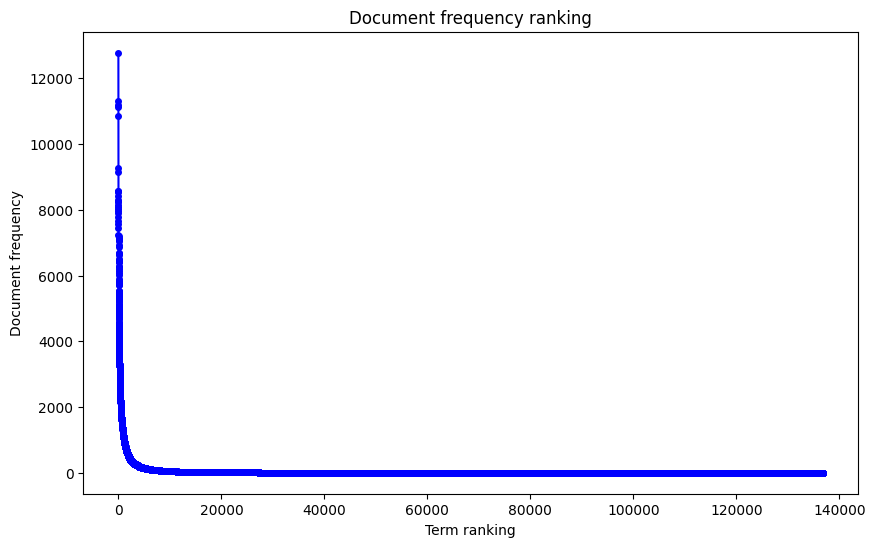

In [44]:
# plot document frequency
# Extract the ranks and document frequencies from df_ranking
ranks = np.arange(1, len(df_ranking) + 1)  # Rank starts from 1
df_frequencies = [score for _, score in df_ranking]  # Document frequencies

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ranks, df_frequencies, marker='o', linestyle='-', color='b', markersize=4)

plt.title('Document frequency ranking')
plt.ylabel("Document frequency")
plt.xlabel("Term ranking")
plt.show()


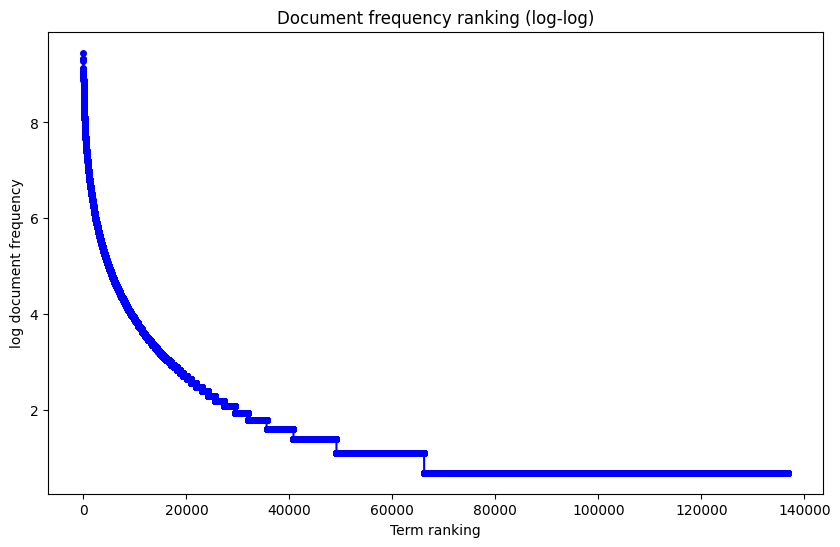

In [45]:
# plot log document frequency
# Extract the ranks and document frequencies from log_df_ranking
ranks2 = np.arange(1, len(log_df_ranking) + 1)  
df_frequencies2 = [score for _, score in log_df_ranking]  

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ranks2, df_frequencies2, marker='o', linestyle='-', color='b', markersize=4)

plt.title('Document frequency ranking (log-log)')
plt.ylabel("log document frequency")
plt.xlabel("Term ranking")
plt.show()


In [46]:
import numpy as np
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to compute term-frequency inverse document frequency (TF-IDF)
def tf_idf_compute(term, num_docs, scores_tf, scores_df):
    return (1 + np.log(scores_tf[term])) * np.log(num_docs / (1 + scores_df[term]))

# Function to chunk tokens
def chunk_tokens(tokens, chunk_size):
    """Generator function to split tokens into chunks."""
    for i in range(0, len(tokens), chunk_size):
        yield tokens[i:i + chunk_size]

tokens = lemmas  # token list
chunk_size = 1000  # Number of rows processed each time

# Dictionary to keep track of term frequency and document frequency for each term
tf_dict = defaultdict(int)  # Term frequency dictionary
df_dict = defaultdict(int)  # Document frequency dictionary
tfidf_dict = defaultdict(float)  # Final TF-IDF values

# Process tokens in chunks
for chunk in chunk_tokens(tokens, chunk_size):
    print(f"Processing chunk of size {len(chunk)}")

    # Generate term-document matrix for the current chunk
    vectorizer = TfidfVectorizer(use_idf=False, norm=None, tokenizer=do_nothing, preprocessor=do_nothing)
    df_matrix = vectorizer.fit_transform(chunk)  # Term-document matrix for the chunk

    # Sum the word frequency matrix across rows to get term frequency for the chunk
    scores_tf = df_matrix.sum(axis=0).A1  # Convert to a 1D array

    # Update document frequency dictionary for each term in the current chunk
    df_matrix_bool = (df_matrix > 0).astype(int)  # Binary matrix (1 if term is present in doc)
    for term, idx in vectorizer.vocabulary_.items():
        df_dict[term] += df_matrix_bool[0, idx]  # Increment document frequency for the term
        tf_dict[term] += scores_tf[idx]  # Increment term frequency for the term

# Calculate TF-IDF for each term across all chunks
num_docs = len(tokens)  # Total number of documents (chunks processed)
for term in df_dict:
    tfidf_dict[term] = tf_idf_compute(term, num_docs, tf_dict, df_dict)

# Sort the terms by their TF-IDF values in descending order
sorted_terms_tfidf = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted terms and their TF-IDF scores
sorted_vocab_keys_tfidf = [term for term, _ in sorted_terms_tfidf]
sorted_scores_tfidf = [score for _, score in sorted_terms_tfidf]

# Display the top 10 terms by TF-IDF
tfidf_ranking = list(zip(sorted_vocab_keys_tfidf, sorted_scores_tfidf))
tfidf_ranking[:10]  # Top 10 ranked terms by TF-IDF


Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 1000
Processing chunk of size 800


[('voter', 97.4740804004918),
 ('clinton', 96.6936279486895),
 ('human', 95.89100158405469),
 ('mrs', 94.86636502773396),
 ('economic', 94.6624048856768),
 ('book', 94.3524876536071),
 ('hard', 93.71298014547048),
 ('child', 93.23982545932044),
 ('idea', 93.13633214977392),
 ('border', 93.06213248999835)]

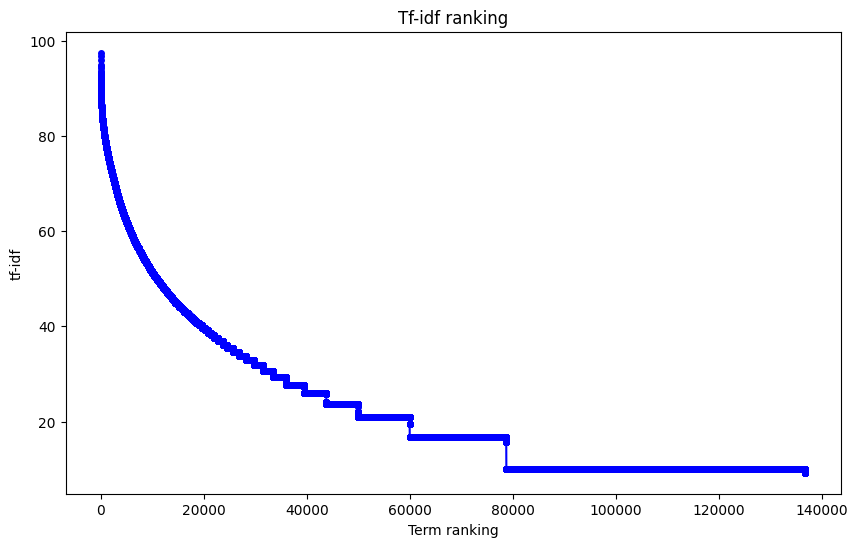

In [47]:
# plot TF-IDF
# Extract the ranks and document frequencies from df_ranking
tfidf_ranks = np.arange(1, len(tfidf_ranking) + 1)  # Rank starts from 1
tfidf_frequencies = [score for _, score in tfidf_ranking]  # Document frequencies

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(tfidf_ranks, tfidf_frequencies, marker='o', linestyle='-', color='b', markersize=4)

plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()


Using the *tfidf* ranking, for instance, we can see that removing stems that have a score lower than the score of stems in positions around 5,800 might be reasonable; they are relatively uninformative and lots of them have a similar score.


In [48]:
# get the score of the stem in position 60000
tfidf_ranking[60000][1]

16.834468467182088

In [49]:
# get the score of the stem in position 60000
tfidf_ranking[60000][0]

'equilar'

In [50]:
# Check how many unique words there are
print(len(tfidf_ranking)) 

136787


In [51]:
# auxiliary function to easily remove undesired tokens
def remove(tokens, to_remove):
    if to_remove:
        return [t for t in tokens if t not in to_remove]
    else:
        return tokens

# function to remove tokens in documents according to their df or tfidf score 
def rank_remove(ranking, docs, min_cutoff_score, max_cutoff_score):

    # define list of tokens to remove
    to_remove_low = set([t[0] for t in ranking if t[1] <= min_cutoff_score])
    to_remove_high = set([t[0] for t in ranking if t[1] > max_cutoff_score])

    # remove tokens
    docs_clean = [remove(d, to_remove_low) for d in docs]
    docs_clean = [remove(d, to_remove_high) for d in docs_clean] 

    return docs_clean

In [52]:
lemmas_clean = rank_remove(tfidf_ranking, lemmas, min_cutoff_score=tfidf_ranking[60000][1], max_cutoff_score=np.inf)

In [53]:
# The number of lemmas after restriction
words_count = 0
for tokens in lemmas_clean:
    words_count += len(tokens)

print(words_count)

8025062


In [54]:
# Number of lemmas before limit
words_count = 0
for tokens in lemmas:
    words_count += len(tokens)

print(words_count)

8120623


In [55]:
len(lemmas_clean)

20800

In [56]:
# calculates and prints the minimum, maximum, average, and median lengths
text_lengths(lemmas_clean)

Minimum text length: 0
Maximum text length: 10913
Average text length: 385.82028846153844
Median text length: 291


In [57]:
len(lemmas_clean)

20800

## 2 Vectorization
I selected **four vectorization representations**, specifically **document frequency** and **TF-IDF** within the Bag-of-Words model, **Word2Vec** within the Word Embedding model, and **Convolutional Neural Network (CNN)** within the Deep Learning model.

### 2.1 Bag of Words

#### 2.1.1 Word frequency

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

In [59]:
# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

In [60]:
# we can also create a weighted vectorizer object
# however we will not use it in the analysis
vectorizer = CountVectorizer(preprocessor=do_nothing,              # apply no additional preprocessing
                                      tokenizer=do_nothing,                 # apply no additional tokenization
                                      lowercase=False,                      # convert all characters to lower-case
                                      strip_accents=None,                   # remove non-ascii characters
                                      stop_words=None,                      # remove stopwords from a built-in list. We can also provide our own list
                                      ngram_range=(1, 1),                   # generate only unigrams
                                      analyzer='word',                      # analysis at the word-level 
                                      max_df=0.9,                           # ignore tokens that have a higher document frequency (can be int or percent)
                                      min_df=0.1,                           # ignore tokens that have a lowe document frequency (can be int or percent)
                                      max_features=None,                    # we could impose a maximum number of vocabulary terms
                                   )                       

vectorizer


CountVectorizer(lowercase=False, max_df=0.9, min_df=0.1,
                preprocessor=<function do_nothing at 0x00000291511E6E60>,
                tokenizer=<function do_nothing at 0x00000291511E6E60>)

In [61]:
# create the document term matrix using cleanedlemmas
df_matrix = vectorizer.fit_transform(lemmas_clean).toarray()
vocabulary_custom = vectorizer.vocabulary_
print(len(vocabulary_custom))

432


In [62]:
vocabulary_custom = sorted(vocabulary_custom)
vocabulary_custom[:10]

['able',
 'accord',
 'account',
 'across',
 'act',
 'action',
 'actually',
 'add',
 'address',
 'administration']

In [63]:
# another way of looking at the vocabulary (ordered by index in the document-term matrix)
vectorizer.get_feature_names_out()

array(['able', 'accord', 'account', 'across', 'act', 'action', 'actually',
       'add', 'address', 'administration', 'agency', 'ago', 'agree',
       'allow', 'almost', 'along', 'already', 'although', 'always',
       'america', 'american', 'americans', 'among', 'announce', 'anyone',
       'anything', 'appear', 'area', 'around', 'article', 'ask', 'attack',
       'attempt', 'authority', 'away', 'bad', 'base', 'become', 'begin',
       'behind', 'believe', 'big', 'bill', 'black', 'book', 'break',
       'breitbart', 'bring', 'build', 'business', 'call', 'campaign',
       'can', 'candidate', 'care', 'carry', 'case', 'cause', 'center',
       'challenge', 'change', 'charge', 'chief', 'child', 'choose',
       'city', 'claim', 'clear', 'clinton', 'close', 'com', 'come',
       'comment', 'community', 'company', 'concern', 'congress',
       'consider', 'continue', 'control', 'country', 'course', 'court',
       'cover', 'create', 'current', 'cut', 'daily', 'day', 'deal',
       'death',

In [64]:
print(df_matrix.shape)  # The shape of the output array
print(df_matrix.dtype)  # Output the data type of array elements, such as float64, etc.

(20800, 432)
int64


#### 2.1.2 TF-IDF

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
# we can also create a weighted vectorizer object
# however we will not use it in the analysis
weighted_vectorizer = TfidfVectorizer(preprocessor=do_nothing,              # apply no additional preprocessing
                                      tokenizer=do_nothing,                 # apply no additional tokenization
                                      lowercase=False,                      # convert all characters to lower-case
                                      strip_accents=None,                   # remove non-ascii characters
                                      stop_words=None,                      # remove stopwords from a built-in list. We can also provide our own list
                                      ngram_range=(1, 1),                   # generate only unigrams
                                      analyzer='word',                      # analysis at the word-level 
                                      max_df=0.9,                           # ignore tokens that have a higher document frequency (can be int or percent)
                                      min_df=0.1,                           # ignore tokens that have a lowe document frequency (can be int or percent)
                                      max_features=None,                    # we could impose a maximum number of vocabulary terms
                                      
                                      use_idf=True,                         # wether to apply inverse document frequency weights
                                      smooth_idf=True,                      # add +1 to idf weighting
                                      sublinear_tf=True                     # add +1 to log(tf)
                                   )                       


weighted_df_matrix = weighted_vectorizer.fit_transform(lemmas_clean).toarray()

In [67]:
print(weighted_df_matrix.shape)  
print(weighted_df_matrix.dtype)  

(20800, 432)
float64


In [68]:
weighted_vocabulary_custom = weighted_vectorizer.vocabulary_
print(len(weighted_vocabulary_custom))

432


In [69]:
# another way of looking at the vocabulary (ordered by index in the document-term matrix)
weighted_vectorizer.get_feature_names_out()

array(['able', 'accord', 'account', 'across', 'act', 'action', 'actually',
       'add', 'address', 'administration', 'agency', 'ago', 'agree',
       'allow', 'almost', 'along', 'already', 'although', 'always',
       'america', 'american', 'americans', 'among', 'announce', 'anyone',
       'anything', 'appear', 'area', 'around', 'article', 'ask', 'attack',
       'attempt', 'authority', 'away', 'bad', 'base', 'become', 'begin',
       'behind', 'believe', 'big', 'bill', 'black', 'book', 'break',
       'breitbart', 'bring', 'build', 'business', 'call', 'campaign',
       'can', 'candidate', 'care', 'carry', 'case', 'cause', 'center',
       'challenge', 'change', 'charge', 'chief', 'child', 'choose',
       'city', 'claim', 'clear', 'clinton', 'close', 'com', 'come',
       'comment', 'community', 'company', 'concern', 'congress',
       'consider', 'continue', 'control', 'country', 'course', 'court',
       'cover', 'create', 'current', 'cut', 'daily', 'day', 'deal',
       'death',

### 2.2 Word Embedding


#### 2.2.1 Word2Vec

In [70]:
from gensim.models import Word2Vec

# Train word2vec model (it takes a while to run)
wordmodel = Word2Vec(lemmas_clean, 
                     vector_size=432,       # Represent each word as a 432-dimensional vector
                     window=5,              # Consider a window of 5 words on either side of the current word when learning vector representations
                     min_count=5,           # Ignore words that appear less than 5 times in the corpus
                     workers=4)             # Use 4 worker threads for parallel processing

wordmodel.train(lemmas_clean, total_examples=len(lemmas_clean), epochs=100)

(786834983, 802506200)

In [71]:
# Obtain the vector of a single word
word_list = list(wordmodel.wv.index_to_key[:1])
vectors_list = [wordmodel.wv.get_vector(word) for word in word_list]

print(vectors_list)

[array([-1.37967432e+00,  1.12848759e+00,  2.29112768e+00,  9.08640385e-01,
        2.90850973e+00, -9.73519981e-01, -2.44137779e-01,  8.60751033e-01,
       -1.71121073e+00, -1.51986015e+00,  3.79908830e-01,  2.83208042e-01,
       -8.94105375e-01,  3.90094936e-01, -1.75233459e+00,  1.33268678e+00,
        1.18274724e+00,  3.41023088e-01, -2.89260983e-01, -9.86262798e-01,
        1.27158618e+00, -1.72689307e+00, -1.45022416e+00,  1.25100696e+00,
       -2.28926420e-01, -1.46099174e+00, -3.10535682e-03, -1.35112619e+00,
       -1.74213916e-01, -3.30926001e-01, -8.79877746e-01,  4.19226959e-02,
        3.72577339e-01,  3.38585414e-02, -2.06256524e-01, -2.36199945e-01,
        2.94137955e-01, -9.97129261e-01, -6.94705367e-01,  3.98206189e-02,
       -5.17238081e-01,  5.50930321e-01, -3.90564847e+00, -4.85996664e-01,
       -5.23125350e-01, -1.07823038e+00, -1.64223701e-01,  1.20842099e+00,
       -5.44269204e-01,  1.51701891e+00, -6.70813560e-01,  1.93016216e-01,
       -4.19702172e-01, 

In [72]:
# Define a function to obtain the vector of a single news text by simple averaging

def get_text_vector(text):
    """
    The function is to obtain the vector representation of a single news text (passed in as a word list after word segmentation).

    parameter:
    text: The word segmentation result of a news text, which is a list containing words, such as ['word1', 'word2', 'word3'].

    Return value:
    Returns the vector representation of this news text, which is a 432-dimensional vector. 
    If the words in the text are not in the model vocabulary, a 432-dimensional vector with all 0s is returned.
    """
    
    # For each word in the text, try to obtain its corresponding word vector from the Word2Vec model
    # Only when the word is in the vocabulary of the model, the corresponding vector can be obtained. 
    # Here, a list of word vectors is generated through list derivation.
    vectors = [wordmodel.wv.get_vector(word) for word in text if word in wordmodel.wv]

    # Determine whether the word vector has been obtained (that is, whether any words in the text are in the model vocabulary)
    if vectors:
        # If word vectors are obtained, use the mean function of the numpy library to find the average of these word vectors 
        # (average by column, axis=0 means column direction)
        # The final average vector is used as the vector representation of this news text
        return np.mean(vectors, axis=0)
    else:
        # If none of the words in the text are in the model vocabulary, return a 432-dimensional vector of all zeros.
        return np.zeros(432)

# Obtain the vector representation of 20,749 news articles to form a 20,749×432 matrix
# Call the get_text_vector function for each news text to obtain its vector representation, 
# and combine the vector representations of all news texts into a list
vectors_list = []
for news in lemmas_clean:
    vectors_list.append(get_text_vector(news))

news_text_vectors = np.array(vectors_list)

In [73]:
print(news_text_vectors.shape)  # 输出数组的形状，例如(3, 3)表示二维数组，有3行3列
print(news_text_vectors.dtype)  # 输出数组元素的数据类型，如float64等


(20800, 432)
float64


In [74]:
news_text_vectors[0]

array([-4.75411713e-02,  1.22975959e-02,  1.55057743e-01,  6.40444923e-03,
        2.00046867e-01, -2.05500409e-01,  2.63562202e-01,  3.46514851e-01,
       -2.13845402e-01, -8.84297788e-01, -3.91474724e-01,  3.33505660e-01,
        1.06155075e-01,  1.69005175e-03, -4.65565436e-02,  4.92563769e-02,
        2.23321140e-01,  6.38381124e-01,  1.98420193e-02, -5.06624341e-01,
        7.05690756e-02, -4.43669945e-01,  1.87917858e-01,  1.19757228e-01,
        3.43710572e-01, -3.72768611e-01, -3.92729975e-02, -5.59812784e-01,
        5.17134905e-01, -1.79445166e-02, -7.79475123e-02,  1.46711797e-01,
       -1.13182694e-01,  8.85034800e-02, -1.52176008e-01,  2.63624907e-01,
       -1.69568658e-02, -4.05267358e-01, -3.20911735e-01,  2.87382871e-01,
       -2.29718700e-01,  1.00935899e-01, -5.35083830e-01,  5.51671050e-02,
       -7.02287778e-02, -3.00471008e-01,  8.37818012e-02, -2.29308456e-01,
       -1.03629552e-01,  3.19152027e-01, -1.70332462e-01,  9.64747593e-02,
       -1.68966606e-01,  

### 2.3 Deep Learning

#### 2.3.1 Convolutional Neural Network (CNN)

In [75]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

In [76]:
# Text preprocessing
# Encode the text using a Tokenizer, converting each word in the text into an integer index
tokenizer = Tokenizer()

# create a vocabulary of unique words and assign a unique integer index to each word
tokenizer.fit_on_texts([" ".join(row) for row in lemmas_clean])  

# convert each text document into a sequence of integer indices, where each index corresponds to a word in the vocabulary
sequences = tokenizer.texts_to_sequences([" ".join(row) for row in lemmas_clean]) 


In [77]:
# calculates and prints the minimum, maximum, average, and median lengths
text_lengths(lemmas_clean)

Minimum text length: 0
Maximum text length: 10913
Average text length: 385.82028846153844
Median text length: 291


In [78]:
# Set the maximum text length and pad the text sequence to make all texts the same length to facilitate subsequent input into the neural network
maxlen = 2000  
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

In [79]:
# Build a convolutional neural network model for text vectorization
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (index starts at 1, so add 1)
embedding_dim = 1000  # Word embedding dimensions can be adjusted as needed

cnnmodel = Sequential([
    Embedding(vocab_size, embedding_dim),  # Embedding layer
    Conv1D(128, 5, activation='relu'),  # Conv layer with 128 filters and kernel size 5
    MaxPooling1D(3),  # Max pooling layer with window size 3
    BatchNormalization(),  # Optional: Add batch normalization to stabilize training
    Dropout(0.5),  # Optional: Add dropout to prevent overfitting
    Flatten(),  # Flatten the output of the conv layers
    Dense(432, activation='relu')  # Fully connected layer with output dimension 432
])


In [80]:
cnn_matrix = cnnmodel.predict(padded_sequences)

650/650 ━━━━━━━━━━━━━━━━━━━━ 130s 198ms/step


In [81]:
cnn_matrix.shape

(20800, 432)

## 3 Machine Learning for Classification Tasks

I trained the machine learning models respectively using the text matrices obtained through vectorization by document frequency, TF-IDF, Word2Vec and Convolutional Neural Network (CNN).

Based on the input features and the news classification task, I adopted four machine learning models, namely Gaussian Naive Bayes model, Random Forest model, Support Vector Machine model and Feedforward Neural Network model.

Under each model, I used the above four vectorized text matrices for training to compare the accuracy differences among different combinations of input features and machine learning models.

In [82]:
from sklearn.model_selection import train_test_split

In [83]:
y = df['label']

In [84]:
# vectorize matrix using Word2Vec
# Split the train and test data
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(news_text_vectors, y, 
                                                random_state = 1, 
                                                train_size = 0.8)

print(f"Training data shape: {Xtrain1.shape}, Test data shape: {Xtest1.shape}")


Training data shape: (16640, 432), Test data shape: (4160, 432)


In [85]:
# vectorize matrix using TF-IDF
# Split the train and test data
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(weighted_df_matrix, y, 
                                                random_state = 1, 
                                                train_size = 0.8)

print(f"Training data shape: {Xtrain2.shape}, Test data shape: {Xtest2.shape}")


Training data shape: (16640, 432), Test data shape: (4160, 432)


In [86]:
# vectorize matrix using document frequency
# Split the train and test data
Xtrain3, Xtest3, ytrain3, ytest3 = train_test_split(df_matrix, y, 
                                                random_state = 1, 
                                                train_size = 0.8)

print(f"Training data shape: {Xtrain3.shape}, Test data shape: {Xtest3.shape}")


Training data shape: (16640, 432), Test data shape: (4160, 432)


In [87]:
# vectorize matrix using CNN
# Split the train and test data
Xtrain4, Xtest4, ytrain4, ytest4 = train_test_split(cnn_matrix, y, 
                                                random_state = 1, 
                                                train_size = 0.8)

print(f"Training data shape: {Xtrain4.shape}, Test data shape: {Xtest4.shape}")


Training data shape: (16640, 432), Test data shape: (4160, 432)


In [88]:
from sklearn.preprocessing import StandardScaler
# Adjust the data to a distribution with mean 0 and standard deviation 1
# Helps improve the training effect of models, especially distance-based models or models optimized by gradient descent
# In tree-based models, standardization does not necessarily have a significant impact on model performance.
scaler = StandardScaler()
Xtrain1 = scaler.fit_transform(Xtrain1)
Xtest1 = scaler.transform(Xtest1)

Xtrain2 = scaler.fit_transform(Xtrain2)
Xtest2 = scaler.transform(Xtest2)

Xtrain3 = scaler.fit_transform(Xtrain3)
Xtest3 = scaler.transform(Xtest3)

Xtrain4 = scaler.fit_transform(Xtrain4)
Xtest4 = scaler.transform(Xtest4)


### 3.1 Gaussian Naive Bayes
The Gaussian Naive Bayes classifier is a variant of the **Naive Bayes classification algorithm**, which assumes that the distribution of features follows a Gaussian distribution (i.e. a normal distribution). This model is often used to handle continuous data, and performs well especially if the data features follow a normal distribution.

**Advantages:** 
- Simple and efficient: Gaussian Naive Bayes is computationally simple and highly efficient, especially when dealing with large datasets.
- Efficient training and prediction: Training and prediction have lower time complexity because it only requires computing the mean and variance for each class.
- Suitable for high-dimensional data: In high-dimensional data (such as word frequency features in text classification tasks), Gaussian Naive Bayes can handle high-dimensional features without being susceptible to overfitting.

**Disadvantages:**  
- Feature independence assumption: Naive Bayes assumes that features are conditionally independent, which is often not true in practical applications and may reduce the accuracy of the model.
- Sensitive to outliers: Because the Gaussian distribution is very sensitive to outliers, outliers in the training data can significantly affect the mean and variance, which in turn affect the classification results.
- Assuming features follow a Gaussian distribution: if the actual distribution of the data is not Gaussian, model performance may degrade

In [89]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()


In [90]:
# vectorize matrix using Word2Vec
# Evaluate the model using cross-validation
scores1 = cross_val_score(gnb_model, Xtrain1, ytrain1, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores1.mean():.4f} ± {scores1.std():.4f}")

Cross-validation score: 0.6957 ± 0.0065


In [91]:
# vectorize matrix using TF-IDF
# Evaluate the model using cross-validation
scores2 = cross_val_score(gnb_model, Xtrain2, ytrain2, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores2.mean():.4f} ± {scores2.std():.4f}")

Cross-validation score: 0.8642 ± 0.0059


In [92]:
# vectorize matrix using document frequency
# Evaluate the model using cross-validation
scores3 = cross_val_score(gnb_model, Xtrain3, ytrain3, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores3.mean():.4f} ± {scores3.std():.4f}")

Cross-validation score: 0.7737 ± 0.0087


In [93]:
# vectorize matrix using CNN
# Evaluate the model using cross-validation
scores4 = cross_val_score(gnb_model, Xtrain4, ytrain4, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores4.mean():.4f} ± {scores4.std():.4f}")

Cross-validation score: 0.6239 ± 0.0088


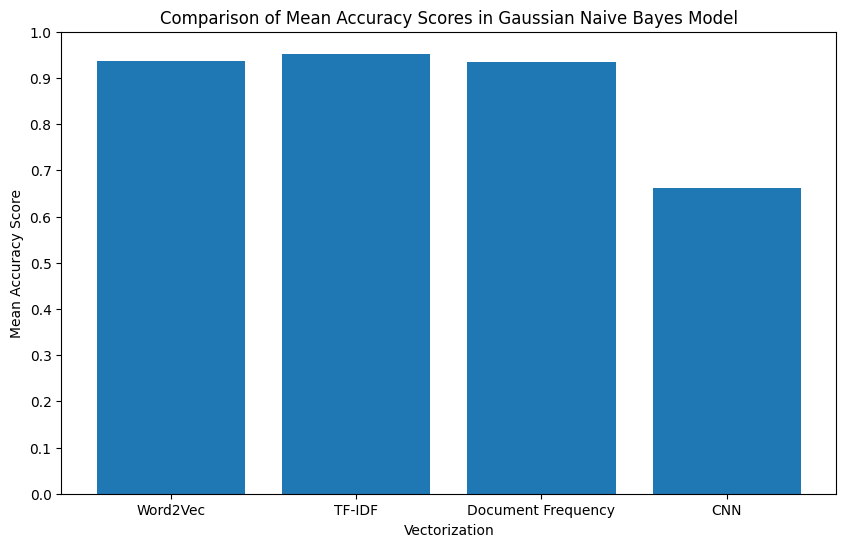

In [ ]:
import matplotlib.pyplot as plt

index = ['Word2Vec', 'TF-IDF', 'Document Frequency', 'CNN']  #  Categories on the x-axis
score = [scores1.mean(), scores2.mean(), scores3.mean(), scores4.mean()]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(10, 6))
plt.ylim([0, 1])
plt.yticks([i * 0.1 for i in range(11)])
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Mean Accuracy Score')  
plt.title('Comparison of Mean Accuracy Scores in Gaussian Naive Bayes Model') 

plt.show()


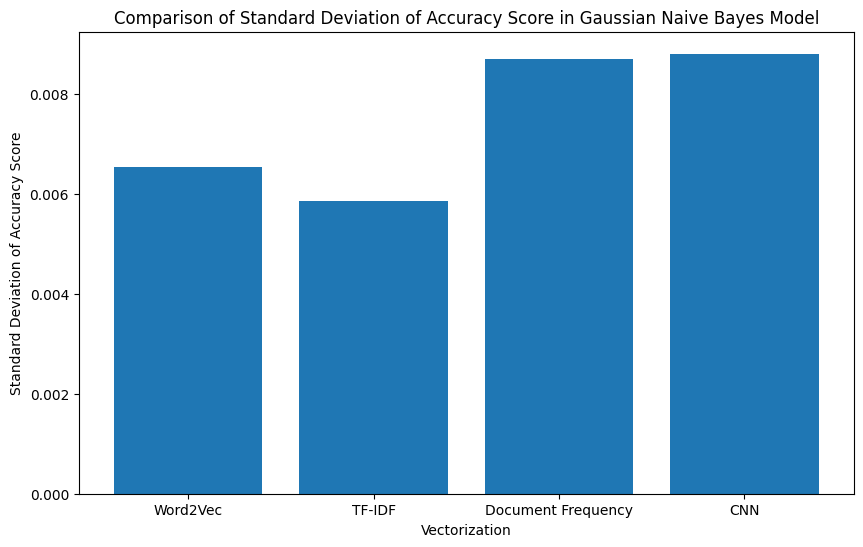

In [95]:
index = ['Word2Vec', 'TF-IDF', 'Document Frequency', 'CNN']  #  Categories on the x-axis
score = [scores1.std(), scores2.std(), scores3.std(), scores4.std()]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(10, 6))
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Standard Deviation of Accuracy Score')  
plt.title('Comparison of Standard Deviation of Accuracy Score in Gaussian Naive Bayes Model') 

plt.show()


**Conclusion:**

It can be clearly seen from the above results that when the settings of the Gaussian Naive Bayes classifier are the same, using the TF-IDF vectorization matrix to classify news, the mean and standard deviation of the model accuracy obtained through cross-validation both show relatively excellent performance. This phenomenon indicates that in this news classification scenario, compared with other input features, the combination of **TF-IDF and the Gaussian Naive Bayes classifier** is more excellent and its generalization ability is also better.

In [97]:
# Use the best combination for final model evaluation
# vectorize matrix using TF-IDF
# Train the model on the training data
gnb_model.fit(Xtrain2, ytrain2)

# Predict on the test data
ypred = gnb_model.predict(Xtest2)

# Evaluate the model accuracy
gnb_accuracy = accuracy_score(ytest2, ypred)

# Output the evaluation result
print('Final Test Accuracy:', gnb_accuracy)

Final Test Accuracy: 0.8576923076923076


### 3.2 Random Forest
Random forest is an ensemble learning algorithm and belongs to the decision tree family. It constructs multiple decision trees and combines their prediction results to improve classification performance. The core idea of random forest is to reduce overfitting and enhance the generalization ability of the model by introducing randomness and ensemble.

**Advantages:**
- High accuracy: By integrating multiple decision trees, random forest usually has a high classification accuracy, especially suitable for large datasets and high-dimensional data.
- Strong resistance to overfitting: Since each tree is trained based on different subsets of samples and features, and the model makes decisions by voting, it can effectively avoid overfitting of a single decision tree.
- Wide applicability: It can handle various types of data, including numerical and categorical features, and also has a relatively good handling of missing values.
- Feature importance: Random forest can calculate the importance of each feature, which is very useful for feature selection and model interpretation.
- Ability to handle large-scale data: It can be trained on relatively large datasets and supports parallel processing, with a relatively fast training speed.

**Disadvantages:**
- Poor model interpretability: As it is an ensemble model, it is difficult to interpret and understand as intuitively as a single decision tree.
- High computational cost: Training multiple trees requires a large amount of computational resources. Especially when the number of samples and features is extremely large, the training time may be relatively long.
- High memory consumption: It needs to store multiple decision trees, so the memory overhead is relatively large, especially when using a large number of trees

In [98]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest classifier
rf_model = RandomForestClassifier(n_estimators=200, # The number of decision trees in the model. Increasing the number of trees generally improves model accuracy, but also increases computational overhead
                                 max_depth=10,  # The maximum depth of the tree. Limiting the depth of the tree prevents overfitting. Depending on the size and characteristics of the dataset, different depths can be tried. Small data sets can use larger depth to prevent underfitting
                                 random_state=42)


In [99]:
# vectorize matrix using Word2Vec
# Evaluate the model using cross-validation
scores1 = cross_val_score(rf_model, Xtrain1, ytrain1, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores1.mean():.4f} ± {scores1.std():.4f}")

Cross-validation score: 0.8709 ± 0.0058


In [100]:
# vectorize matrix using TF-IDF
# Evaluate the model using cross-validation
scores2 = cross_val_score(rf_model, Xtrain2, ytrain2, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores2.mean():.4f} ± {scores2.std():.4f}")

Cross-validation score: 0.9385 ± 0.0032


In [101]:
# vectorize matrix using document frequency
# Evaluate the model using cross-validation
scores3 = cross_val_score(rf_model, Xtrain3, ytrain3, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores3.mean():.4f} ± {scores3.std():.4f}")

Cross-validation score: 0.9361 ± 0.0032


In [102]:
# vectorize matrix using CNN
# Evaluate the model using cross-validation
scores4 = cross_val_score(rf_model, Xtrain4, ytrain4, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores4.mean():.4f} ± {scores4.std():.4f}")

Cross-validation score: 0.6487 ± 0.0068


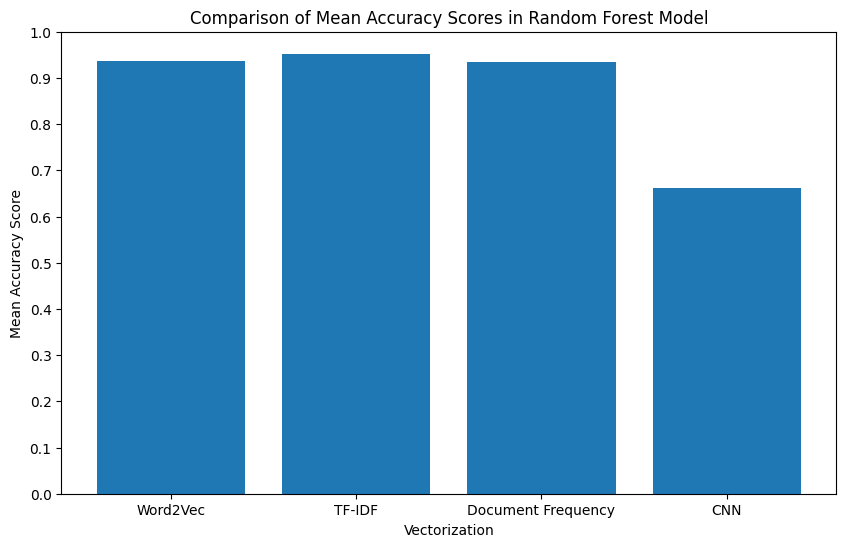

In [136]:

index = ['Word2Vec', 'TF-IDF', 'Document Frequency', 'CNN']  #  Categories on the x-axis
score = [scores1.mean(), scores2.mean(), scores3.mean(), scores4.mean()]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(10, 6))
plt.ylim([0, 1])
plt.yticks([i * 0.1 for i in range(11)])
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Mean Accuracy Score')  
plt.title('Comparison of Mean Accuracy Scores in Random Forest Model') 

plt.show()

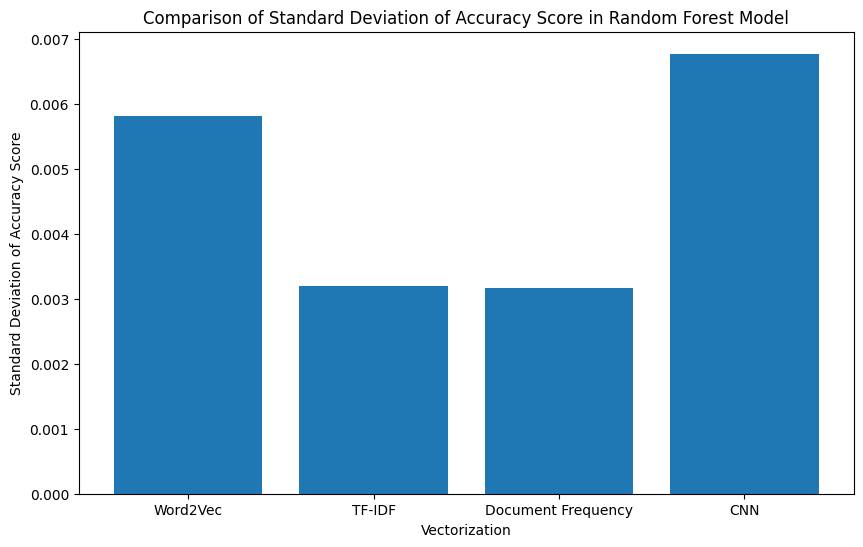

In [104]:
index = ['Word2Vec', 'TF-IDF', 'Document Frequency', 'CNN']  #  Categories on the x-axis
score = [scores1.std(), scores2.std(), scores3.std(), scores4.std()]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(10, 6))
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Standard Deviation of Accuracy Score')  
plt.title('Comparison of Standard Deviation of Accuracy Score in Random Forest Model') 

plt.show()

**Conclusion:**

It can be clearly seen from the above results that when the settings of the random forest model are the same, using the TF-IDF vectorization matrix to classify news, the mean and standard deviation of the model accuracy obtained through cross-validation both show relatively excellent performance. This phenomenon indicates that in this news classification scenario, compared with other input features, the combination of **TF-IDF and the random forest model** is more excellent and its generalization ability is also better.

In [105]:
# Use the best combination for final model evaluation
# vectorize matrix using TF-IDF
# Train the model on the training data
rf_model.fit(Xtrain2, ytrain2)

ypred = rf_model.predict(Xtest2) 

rf_accuracy = accuracy_score(ytest2, ypred)

# Output evaluation report
print('Final Test Accuracy:', rf_accuracy)

Final Test Accuracy: 0.9454326923076923


### 3.3 Support Vector Machine
The Support Vector Machine (SVM) is a powerful supervised learning algorithm, which is widely used in classification and regression tasks. Its core idea is to find a hyperplane (or a set of hyperplanes) in the feature space to separate data points of different classes and maximize the margin between classes so as to improve the generalization ability of the model.

**Advantages:**
- High efficiency: For high-dimensional data (such as in text classification, image classification, etc.), the SVM performs excellently.
- Good generalization ability: By maximizing the margin, the SVM can effectively avoid overfitting, especially suitable for small-sample learning.
- Low memory requirement: The SVM only needs to store the support vectors, so it is relatively efficient when dealing with high-dimensional data.

**Disadvantages:**
- High computational cost: When the number of samples is large, the computational complexity of the training process is relatively high, especially when dealing with larger datasets or higher-dimensional feature data.
- Sensitivity to noise: Although the use of soft margin can tolerate some classification errors, the SVM is still relatively sensitive to noise and outliers.
- Difficulty in selecting kernel functions: In some cases, it may be rather difficult to select appropriate kernel functions and parameters (such as C and γ).

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

svc_model = SVC(kernel='rbf', C=1.0)


In [107]:
# vectorize matrix using Word2Vec
# Evaluate the model using cross-validation
scores1 = cross_val_score(svc_model, Xtrain1, ytrain1, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores1.mean():.4f} ± {scores1.std():.4f}")

Cross-validation score: 0.9367 ± 0.0031


In [108]:
# vectorize matrix using TF-IDF
# Evaluate the model using cross-validation
scores2 = cross_val_score(svc_model, Xtrain2, ytrain2, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores2.mean():.4f} ± {scores2.std():.4f}")

Cross-validation score: 0.9513 ± 0.0020


In [109]:
# vectorize matrix using document frequency
# Evaluate the model using cross-validation
scores3 = cross_val_score(svc_model, Xtrain3, ytrain3, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores3.mean():.4f} ± {scores3.std():.4f}")

Cross-validation score: 0.9334 ± 0.0046


In [110]:
# vectorize matrix using CNN
# Evaluate the model using cross-validation
scores4 = cross_val_score(svc_model, Xtrain4, ytrain4, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores4.mean():.4f} ± {scores4.std():.4f}")

Cross-validation score: 0.6621 ± 0.0061


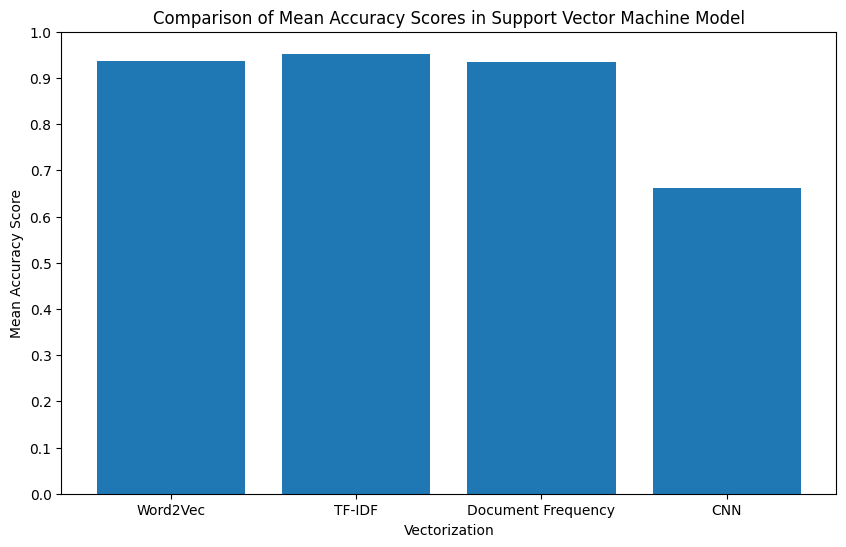

In [137]:
index = ['Word2Vec', 'TF-IDF', 'Document Frequency', 'CNN']  #  Categories on the x-axis
score = [scores1.mean(), scores2.mean(), scores3.mean(), scores4.mean()]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(10, 6))
plt.ylim([0, 1])
plt.yticks([i * 0.1 for i in range(11)])
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Mean Accuracy Score')  
plt.title('Comparison of Mean Accuracy Scores in Support Vector Machine Model') 

plt.show()

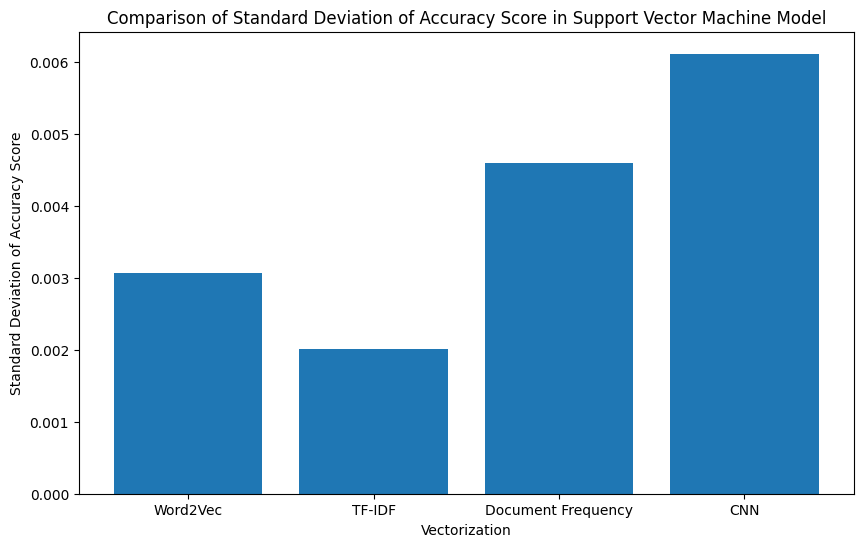

In [112]:
index = ['Word2Vec', 'TF-IDF', 'Document Frequency', 'CNN']  #  Categories on the x-axis
score = [scores1.std(), scores2.std(), scores3.std(), scores4.std()]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(10, 6))
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Standard Deviation of Accuracy Score')  
plt.title('Comparison of Standard Deviation of Accuracy Score in Support Vector Machine Model') 

plt.show()

**Conclusion:**

It can be clearly seen from the above results that when the settings of the Gaussian Naive Bayes classifier are the same, using the TF-IDF vectorization matrix to classify news, the mean and standard deviation of the model accuracy obtained through cross-validation both show relatively excellent performance. This phenomenon indicates that in this news classification scenario, compared with other input features, the combination of **TF-IDF and the Support Vector Machine model** is more excellent and its generalization ability is also better.

In [113]:
# Use the best combination for final model evaluation
# vectorize matrix using TF-IDF
# Train the model on the training data
svc_model.fit(Xtrain2, ytrain2)

ypred = svc_model.predict(Xtest2) 

svc_accuracy = accuracy_score(ytest2, ypred)

# Output the evaluation result
print('Final Test Accuracy:', svc_accuracy)

Final Test Accuracy: 0.9557692307692308


### 3.4 Feedforward neural network
Feedforward Neural Network (shortened as FNN) is one of the most basic architectures of artificial neural networks. It is composed of an input layer, hidden layers and an output layer. Among these layers, information flows only in one direction, that is, from the input layer to the output layer, without any feedback loops. In classification tasks, FNN is used to learn the nonlinear relationships between input data and target labels. The nodes (neurons) in each layer transform the input through activation functions and then pass the results to the next layer.

Advantages:
- Strong expressive ability: FNN can approximate any complex nonlinear function (according to the Universal Approximation Theorem), so it can handle very complex classification tasks.
- High flexibility: By increasing the number of hidden layers and neurons, the network can handle more complex patterns to a certain extent.
- No feature engineering required: Compared with traditional machine learning methods, FNN doesn't need to design features manually and only requires raw data.

Disadvantages:
- High computational complexity: For large datasets and complex models, the training of FNN may take a long time, especially when the network is deep.
- Overfitting risk: If there are too many hidden layers or too little training data, FNN is prone to overfitting. Therefore, regularization (such as Dropout) and hyperparameter tuning are needed.
- Poor interpretability: As a black-box model, FNN is not as easy to interpret as models like decision trees. So it may not be applicable in some scenarios where model interpretation is required

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [115]:
# split and transfer data
def split_trans (matrix):
    # The first split, 80% training set, 20% temporary set (validation set + test set)
    X_train, X_temp, y_train, y_temp = train_test_split(matrix, y, test_size=0.2, random_state=42)
    # Second split, 50% validation set, 50% test set
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    print(X_train.shape, X_val.shape, X_test.shape)

    # Adjust the data to a distribution with mean 0 and standard deviation 1
    # Helps improve the training effect of models, especially distance-based models or models optimized by gradient descent
    # In tree-based models, standardization does not necessarily have a significant impact on model performance.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)  # Use only the normalized parameters of the training set
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch Tensor
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Label is of type integer
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    return X_train_scaled, X_val_scaled, X_test_scaled, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor




In [116]:
# Define FNN model
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # A fully connected (dense) layer
        self.relu = nn.ReLU()                           # ReLU activation function, which introduces non-linearity to the model
        self.fc2 = nn.Linear(hidden_size, output_size)  # Another fully connected layer
        self.softmax = nn.LogSoftmax(dim=1)             # A log softmax activation function, which is often used in the output layer of a classification model to produce a probability distribution over classes
        self.dropout = nn.Dropout(p=0.2)                # A dropout layer with a dropout probability of 0.2, which randomly sets 20% of the neurons to zero during training to prevent overfitting

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout here
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [117]:
# Training function
def train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=100, lr=0.001):
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  # Learning rate scheduler

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_val_tensor)
                _, predicted = torch.max(test_outputs, 1)
                test_accuracy = accuracy_score(y_val_tensor, predicted)
                print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Evaluation Accuracy: {test_accuracy:.4f}")
                
    return model

In [118]:
# Call the function to split and process data
X_train_scaled, X_val_scaled, X_test_scaled, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = split_trans(matrix=news_text_vectors)

(16640, 432) (2080, 432) (2080, 432)


In [119]:
# Model parameters
input_size = X_train_scaled.shape[1]
hidden_size = 1000
output_size = 2

# Initialize model
fnn_model = FNN(input_size, hidden_size, output_size)

# Training model
fnn_model1 = train_model(fnn_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=200, lr=0.001)


Epoch [10/200], Loss: 0.2850, Evaluation Accuracy: 0.8837
Epoch [20/200], Loss: 0.2084, Evaluation Accuracy: 0.9149
Epoch [30/200], Loss: 0.1638, Evaluation Accuracy: 0.9212
Epoch [40/200], Loss: 0.1306, Evaluation Accuracy: 0.9274
Epoch [50/200], Loss: 0.1059, Evaluation Accuracy: 0.9308
Epoch [60/200], Loss: 0.1012, Evaluation Accuracy: 0.9317
Epoch [70/200], Loss: 0.0977, Evaluation Accuracy: 0.9327
Epoch [80/200], Loss: 0.0947, Evaluation Accuracy: 0.9322
Epoch [90/200], Loss: 0.0939, Evaluation Accuracy: 0.9332
Epoch [100/200], Loss: 0.0909, Evaluation Accuracy: 0.9313
Epoch [110/200], Loss: 0.0905, Evaluation Accuracy: 0.9313
Epoch [120/200], Loss: 0.0899, Evaluation Accuracy: 0.9317
Epoch [130/200], Loss: 0.0898, Evaluation Accuracy: 0.9317
Epoch [140/200], Loss: 0.0897, Evaluation Accuracy: 0.9308
Epoch [150/200], Loss: 0.0883, Evaluation Accuracy: 0.9308
Epoch [160/200], Loss: 0.0877, Evaluation Accuracy: 0.9308
Epoch [170/200], Loss: 0.0895, Evaluation Accuracy: 0.9308
Epoch 

In [120]:
# using test data to evaluate
fnn_model1.eval()  # Enter evaluation mode
with torch.no_grad():
    test_outputs = fnn_model1(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    fnn_accuracy1 = accuracy_score(y_test_tensor, predicted)
    print(f"Final Test Accuracy: {fnn_accuracy1:.4f}")


Final Test Accuracy: 0.9385


In [121]:
# vectorize matrix using TF-IDF 
X_train_scaled, X_val_scaled, X_test_scaled, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = split_trans(matrix=weighted_df_matrix)

(16640, 432) (2080, 432) (2080, 432)


In [122]:
# Model parameters
input_size = X_train_scaled.shape[1]
hidden_size = 1000
output_size = 2

# Initialize model
fnn_model = FNN(input_size, hidden_size, output_size)

# Training model
fnn_model2 = train_model(fnn_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=200, lr=0.001)


Epoch [10/200], Loss: 0.2875, Evaluation Accuracy: 0.8625
Epoch [20/200], Loss: 0.1827, Evaluation Accuracy: 0.9038
Epoch [30/200], Loss: 0.1183, Evaluation Accuracy: 0.9255
Epoch [40/200], Loss: 0.0759, Evaluation Accuracy: 0.9341
Epoch [50/200], Loss: 0.0461, Evaluation Accuracy: 0.9361
Epoch [60/200], Loss: 0.0416, Evaluation Accuracy: 0.9365
Epoch [70/200], Loss: 0.0395, Evaluation Accuracy: 0.9375
Epoch [80/200], Loss: 0.0373, Evaluation Accuracy: 0.9380
Epoch [90/200], Loss: 0.0352, Evaluation Accuracy: 0.9380
Epoch [100/200], Loss: 0.0333, Evaluation Accuracy: 0.9385
Epoch [110/200], Loss: 0.0330, Evaluation Accuracy: 0.9389
Epoch [120/200], Loss: 0.0332, Evaluation Accuracy: 0.9389
Epoch [130/200], Loss: 0.0324, Evaluation Accuracy: 0.9389
Epoch [140/200], Loss: 0.0328, Evaluation Accuracy: 0.9389
Epoch [150/200], Loss: 0.0323, Evaluation Accuracy: 0.9389
Epoch [160/200], Loss: 0.0318, Evaluation Accuracy: 0.9389
Epoch [170/200], Loss: 0.0318, Evaluation Accuracy: 0.9389
Epoch 

In [123]:
# using test data to evaluate
fnn_model2.eval()  # Enter evaluation mode
with torch.no_grad():
    test_outputs = fnn_model2(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    fnn_accuracy2 = accuracy_score(y_test_tensor, predicted)
    print(f"Final Test Accuracy: {fnn_accuracy2:.4f}")


Final Test Accuracy: 0.9452


In [124]:
# vectorize matrix using document frequency 
X_train_scaled, X_val_scaled, X_test_scaled, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = split_trans(matrix=df_matrix)

(16640, 432) (2080, 432) (2080, 432)


In [125]:
# Model parameters
input_size = X_train_scaled.shape[1]
hidden_size = 1000
output_size = 2

# Initialize model
fnn_model = FNN(input_size, hidden_size, output_size)

# Training model
fnn_model3 = train_model(fnn_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=200, lr=0.001)


Epoch [10/200], Loss: 0.3299, Evaluation Accuracy: 0.8635
Epoch [20/200], Loss: 0.2244, Evaluation Accuracy: 0.8913
Epoch [30/200], Loss: 0.1654, Evaluation Accuracy: 0.9067
Epoch [40/200], Loss: 0.1249, Evaluation Accuracy: 0.9168
Epoch [50/200], Loss: 0.0951, Evaluation Accuracy: 0.9216
Epoch [60/200], Loss: 0.0914, Evaluation Accuracy: 0.9226
Epoch [70/200], Loss: 0.0886, Evaluation Accuracy: 0.9236
Epoch [80/200], Loss: 0.0861, Evaluation Accuracy: 0.9236
Epoch [90/200], Loss: 0.0831, Evaluation Accuracy: 0.9240
Epoch [100/200], Loss: 0.0807, Evaluation Accuracy: 0.9245
Epoch [110/200], Loss: 0.0814, Evaluation Accuracy: 0.9245
Epoch [120/200], Loss: 0.0804, Evaluation Accuracy: 0.9245
Epoch [130/200], Loss: 0.0800, Evaluation Accuracy: 0.9245
Epoch [140/200], Loss: 0.0794, Evaluation Accuracy: 0.9245
Epoch [150/200], Loss: 0.0801, Evaluation Accuracy: 0.9245
Epoch [160/200], Loss: 0.0798, Evaluation Accuracy: 0.9245
Epoch [170/200], Loss: 0.0799, Evaluation Accuracy: 0.9245
Epoch 

In [126]:
# using test data to evaluate
fnn_model3.eval()  # Enter evaluation mode
with torch.no_grad():
    test_outputs = fnn_model3(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    fnn_accuracy3 = accuracy_score(y_test_tensor, predicted)
    print(f"Final Test Accuracy: {fnn_accuracy3:.4f}")


Final Test Accuracy: 0.9365


In [127]:
# vectorize matrix using CNN 
X_train_scaled, X_val_scaled, X_test_scaled, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = split_trans(matrix=cnn_matrix)

(16640, 432) (2080, 432) (2080, 432)


In [128]:
# Model parameters
input_size = X_train_scaled.shape[1]
hidden_size = 1000
output_size = 2

# Initialize model
fnn_model = FNN(input_size, hidden_size, output_size)

# Training model
fnn_model4 = train_model(fnn_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=200, lr=0.001)


Epoch [10/200], Loss: 0.6049, Evaluation Accuracy: 0.6332
Epoch [20/200], Loss: 0.5653, Evaluation Accuracy: 0.6500
Epoch [30/200], Loss: 0.5359, Evaluation Accuracy: 0.6476
Epoch [40/200], Loss: 0.4970, Evaluation Accuracy: 0.6548
Epoch [50/200], Loss: 0.4490, Evaluation Accuracy: 0.6587
Epoch [60/200], Loss: 0.4364, Evaluation Accuracy: 0.6625
Epoch [70/200], Loss: 0.4286, Evaluation Accuracy: 0.6639
Epoch [80/200], Loss: 0.4217, Evaluation Accuracy: 0.6630
Epoch [90/200], Loss: 0.4137, Evaluation Accuracy: 0.6644
Epoch [100/200], Loss: 0.4058, Evaluation Accuracy: 0.6620
Epoch [110/200], Loss: 0.4043, Evaluation Accuracy: 0.6620
Epoch [120/200], Loss: 0.4030, Evaluation Accuracy: 0.6611
Epoch [130/200], Loss: 0.4027, Evaluation Accuracy: 0.6615
Epoch [140/200], Loss: 0.4023, Evaluation Accuracy: 0.6615
Epoch [150/200], Loss: 0.3996, Evaluation Accuracy: 0.6615
Epoch [160/200], Loss: 0.3998, Evaluation Accuracy: 0.6615
Epoch [170/200], Loss: 0.4009, Evaluation Accuracy: 0.6615
Epoch 

In [129]:
# using test data to evaluate
fnn_model4.eval()  # Enter evaluation mode
with torch.no_grad():
    test_outputs = fnn_model4(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    fnn_accuracy4 = accuracy_score(y_test_tensor, predicted)
    print(f"Final Test Accuracy: {fnn_accuracy4:.4f}")


Final Test Accuracy: 0.6404


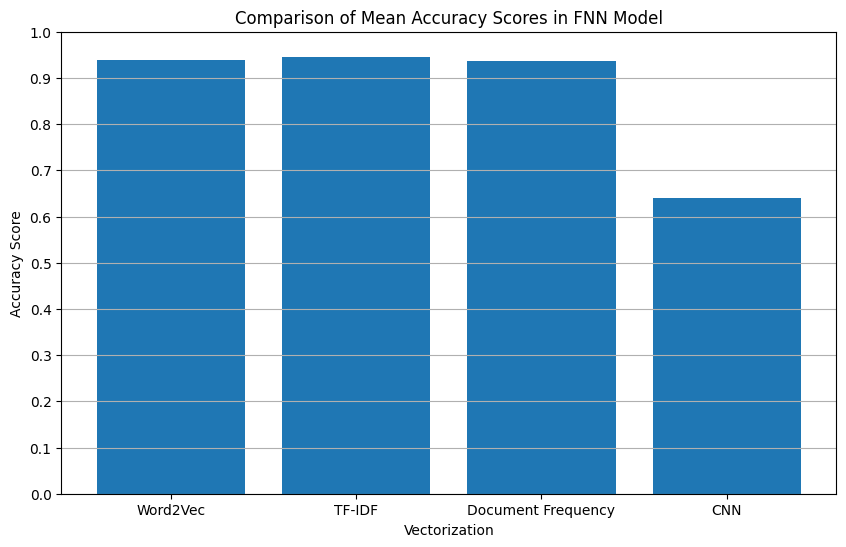

In [141]:
index = ['Word2Vec', 'TF-IDF', 'Document Frequency', 'CNN']  #  Categories on the x-axis
score = [fnn_accuracy1, fnn_accuracy2, fnn_accuracy3, fnn_accuracy4]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(10, 6))
plt.ylim([0, 1])
plt.yticks([i * 0.1 for i in range(11)])
plt.grid(axis='y')  # adds grid lines to the y-axis
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Accuracy Score')  
plt.title('Comparison of Mean Accuracy Scores in FNN Model') 

plt.show()

It can be seen from the above results that when the settings of the FNN model remain the same, the input features represented by the three vectorization methods, namely TF-IDF, document frequency and Word2Vec, all enable the model to achieve a relatively high accuracy. However, the combination of **TF-IDF and the FNN model** has a slight edge.

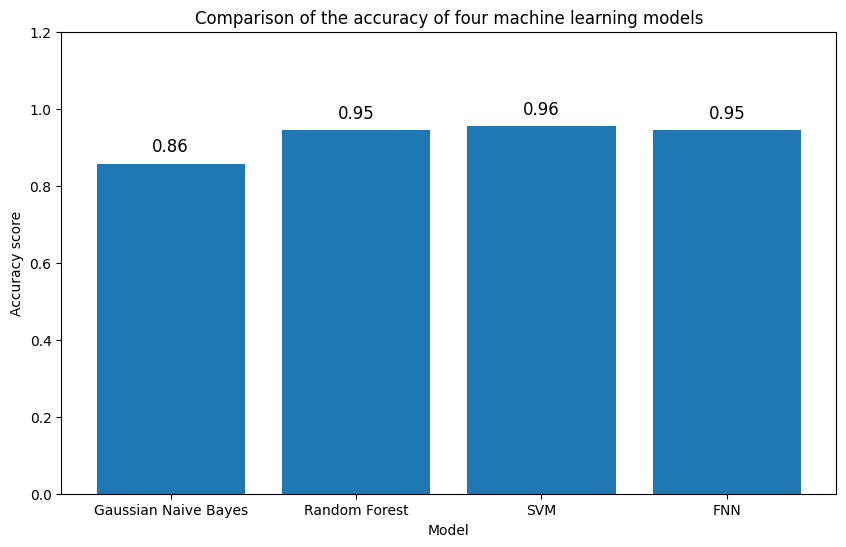

In [ ]:
index = ['Gaussian Naive Bayes', 'Random Forest', 'SVM', 'FNN']  #  Categories on the x-axis
score = [gnb_accuracy, rf_accuracy, svc_accuracy, fnn_accuracy2]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(10, 6))
plt.ylim([0, 1.2])

# Add text labels above each bar
bars = plt.bar(index, score)
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02,  # Adjust the position of the text
             f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

# Add tags and titles
plt.xlabel('Model')  
plt.ylabel('Accuracy score')  
plt.title('Comparison of the accuracy of four machine learning models') 

plt.show()

In [148]:
print('The best accuracy score is', svc_accuracy)

The best accuracy score is 0.9557692307692308


## 4 Conclusion
- After controlling the dimensions of the input features to be consistent, compared with the text vector matrices represented by the other three vectorization methods, the models obtained by combining TF-IDF with the four machine learning models have the most excellent accuracy and generalization ability.

- After controlling the input feature to be the **TF-IDF text vector matrix**, the performances of the Random Forest, Support Vector Machine, and Feedforward Neural Network models are all relatively good. Among them, **the Support Vector Machine model equipped with a nonlinear kernel** has the best accuracy in the news classification task.